<a href="https://colab.research.google.com/github/Matvej911/Matvejs_edgeAi/blob/main/age_gender_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall tensorflow -y


Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0


In [ ]:
!pip install tensorflow==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [ ]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.14.0


### This section mounts your Google Drive to Colab so you can access files stored there.
### You need to grant permission when prompted, and your Google Drive will be available at `/content/drive`.

Before running the following code, please ensure you have uploaded your dataset to Google Drive. Follow these steps:

Prepare Your Dataset:

Make sure your dataset is in a zip file format, named archive1.zip.
The zip file should contain your training and validation images organized into separate directories for each emotion.
Upload to Google Drive:

Upload the emotion.zip file to your Google Drive. You can place it in any folder, but for simplicity, you might want to place it in the root directory of your Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/archive/archive1.zip" /content/

In [ ]:
import zipfile
import os

zip_path = '/content/archive1.zip'
extract_path = '/content/utkface_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir(extract_path))

['UTKFace']


### Data Preparation for Age and Gender Prediction using UTKFace Dataset

The processed images are normalized, and the dataset is split into training and testing sets for both age and gender prediction tasks. The entire process is designed to facilitate further model training and evaluation in deep learning applications.

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split

BASE_DIR = '/content/utkface_dataset/UTKFace'

image_paths = []
age_labels = []
gender_labels = []


for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')


    if len(temp) >= 2:
        age = int(temp[0])
        gender = int(temp[1])
        image_paths.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)


df = pd.DataFrame({
    'image': image_paths,
    'age': age_labels,
    'gender': gender_labels
})


def extract_features(images, limit=8000):
    features = []

    for i, image in enumerate(tqdm(images[:limit])):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128))
        img = np.array(img)
        features.append(img)

        if i + 1 == limit:
            break

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

X = extract_features(df['image'], limit=8000)

X = X / 255.0

print("Shape of X:", X.shape)

y_gender = np.array(df['gender'][:len(X)])
y_age = np.array(df['age'][:len(X)])  h

X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X, y_gender, test_size=0.2, random_state=42)

X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, y_age, test_size=0.2, random_state=42)


100%|██████████| 23708/23708 [00:00<00:00, 80019.89it/s]


                                               image  age  gender
0  /content/utkface_dataset/UTKFace/28_0_1_201701...   28       0
1  /content/utkface_dataset/UTKFace/68_0_0_201701...   68       0
2  /content/utkface_dataset/UTKFace/26_1_3_201701...   26       1
3  /content/utkface_dataset/UTKFace/40_0_1_201701...   40       0
4  /content/utkface_dataset/UTKFace/15_0_0_201701...   15       0


100%|█████████▉| 7999/8000 [00:10<00:00, 763.01it/s] 


Shape of X: (8000, 128, 128, 1)


### Building Gender and Age Prediction Models Using Convolutional Neural Networks

####Creating the Gender Model:

A CNN architecture is defined with two convolutional layers followed by max pooling layers, a flattening layer, and a dense layer. The model outputs a binary classification for gender using the sigmoid activation function. The model is compiled with binary cross-entropy loss, suitable for binary classification tasks.

####Creating the Age Model:

Similar to the gender model, this architecture also includes two convolutional layers and max pooling. However, it outputs a single continuous value representing age, with mean absolute error (MAE) as the loss function for regression tasks.

In [ ]:
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model

def create_gender_model(input_shape):
    inputs = Input(input_shape)
    conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
    conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
    maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
    flatten = Flatten()(maxp_2)
    dense = Dense(128, activation='relu')(flatten)
    output = Dense(1, activation='sigmoid', name='gender_output')(dense)

    model = Model(inputs=[inputs], outputs=[output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def create_age_model(input_shape):
    inputs = Input(input_shape)

    conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
    conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
    maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
    flatten = Flatten()(maxp_2)
    dense = Dense(128, activation='relu')(flatten)
    output = Dense(1, name='age_output')(dense)

    model = Model(inputs=[inputs], outputs=[output])
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])
    return model

input_shape = (128, 128, 1)

gender_model = create_gender_model(input_shape)
age_model = create_age_model(input_shape)

print("Training Gender Model...")
gender_history = gender_model.fit(X_train_gender, y_train_gender,
                                   validation_data=(X_test_gender, y_test_gender),
                                   epochs=30, batch_size=32)

print("Training Age Model...")
age_history = age_model.fit(X_train_age, y_train_age,
                            validation_data=(X_test_age, y_test_age),
                            epochs=30, batch_size=32)

gender_model.save('gender_model.h5')
age_model.save('age_model.h5')


Training Gender Model...
Epoch 1/30
200/200 [==============================] - 151s 749ms/step - loss: 0.5045 - accuracy: 0.7584 - val_loss: 0.4138 - val_accuracy: 0.8144
Epoch 2/30
200/200 [==============================] - 159s 797ms/step - loss: 0.3538 - accuracy: 0.8428 - val_loss: 0.3447 - val_accuracy: 0.8506
Epoch 3/30
200/200 [==============================] - 209s 1s/step - loss: 0.3109 - accuracy: 0.8644 - val_loss: 0.3553 - val_accuracy: 0.8500
Epoch 4/30
200/200 [==============================] - 155s 775ms/step - loss: 0.2671 - accuracy: 0.8886 - val_loss: 0.3252 - val_accuracy: 0.8669
Epoch 5/30
200/200 [==============================] - 157s 785ms/step - loss: 0.2218 - accuracy: 0.9100 - val_loss: 0.3635 - val_accuracy: 0.8581
Epoch 6/30
200/200 [==============================] - 166s 833ms/step - loss: 0.1865 - accuracy: 0.9244 - val_loss: 0.3256 - val_accuracy: 0.8725
Epoch 7/30
200/200 [==============================] - 160s 799ms/step - loss: 0.1463 - accuracy: 0.943

In [ ]:
gender_dict = {0:'Male', 1:'Female'}

### Visualizing Gender and Age Predictions on random image

Original Gender: Male Original Age: 69
1/1 [==============================] - 0s 51ms/step
Predicted Gender: Male Predicted Age: 63


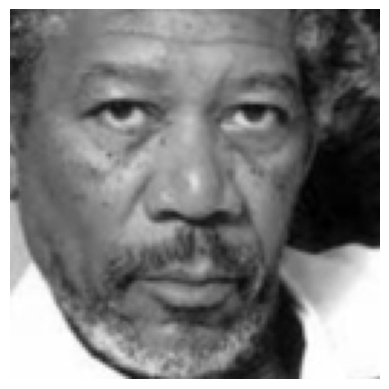

In [ ]:
import matplotlib.pyplot as plt

image_index = 200

print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

image_to_predict = X[image_index].reshape(1, 128, 128, 1)

pred_gender = gender_model.predict(image_to_predict)
pred_gender_class = round(pred_gender[0][0])
pred_gender_label = gender_dict[pred_gender_class]

pred_age = age_model.predict(image_to_predict)
pred_age_value = round(pred_age[0][0])

print("Predicted Gender:", pred_gender_label, "Predicted Age:", pred_age_value)

plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')
plt.show()

In [ ]:
gender_model.save('gender_model.h5')
age_model.save('age_model.h5')

### Extracting and Resizing Faces from Images using OpenCV

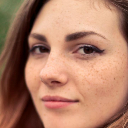

In [65]:
def extract_and_resize_face(image_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    image = cv2.imread(image_path)
    if image is None:
        print("Could not read the image.")
        return None

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No faces found.")
        return None


    (x, y, w, h) = faces[0]
    face_image = image[y:y + h, x:x + w]

    face_image_resized = cv2.resize(face_image, (128, 128))

    return face_image_resized

output_face = extract_and_resize_face('w_26_happy.jpg')
if output_face is not None:
    cv2_imshow(output_face)
    cv2.imwrite('output_face.jpg', output_face)

### Converting Keras Models to TensorFlow Lite Format

In [ ]:
gender_model = tf.keras.models.load_model('gender_model.h5')
age_model = tf.keras.models.load_model('age_model.h5')

gender_converter = tf.lite.TFLiteConverter.from_keras_model(gender_model)
age_converter = tf.lite.TFLiteConverter.from_keras_model(age_model)

gender_converter.optimizations = [tf.lite.Optimize.DEFAULT]
age_converter.optimizations = [tf.lite.Optimize.DEFAULT]

gender_tflite_model = gender_converter.convert()
age_tflite_model = age_converter.convert()

with open('gender_model.tflite', 'wb') as f:
    f.write(gender_tflite_model)

with open('age_model.tflite', 'wb') as f:
    f.write(age_tflite_model)

### Gender and Age Prediction Using TensorFlow Lite Models

Predicted Gender: Male
Predicted Age: 16


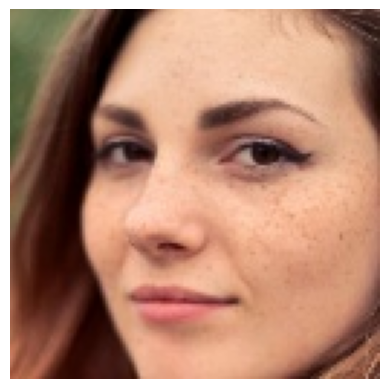

In [66]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt


gender_interpreter = tf.lite.Interpreter(model_path='gender_model.tflite')
age_interpreter = tf.lite.Interpreter(model_path='age_model.tflite')

gender_interpreter.allocate_tensors()
age_interpreter.allocate_tensors()


gender_input_details = gender_interpreter.get_input_details()
gender_output_details = gender_interpreter.get_output_details()

age_input_details = age_interpreter.get_input_details()
age_output_details = age_interpreter.get_output_details()


image_path = '/content/output_face.jpg'


def preprocess_image(image_path):

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    img = np.array(img, dtype=np.float32) / 255.0
    img = img.reshape(1, 128, 128, 1)
    return img

def predict(image_path):

    processed_image = preprocess_image(image_path)


    gender_interpreter.set_tensor(gender_input_details[0]['index'], processed_image)
    gender_interpreter.invoke()
    gender_prediction = gender_interpreter.get_tensor(gender_output_details[0]['index'])


    age_interpreter.set_tensor(age_input_details[0]['index'], processed_image)
    age_interpreter.invoke()
    age_prediction = age_interpreter.get_tensor(age_output_details[0]['index'])

    gender_dict = {0: 'Male', 1: 'Female'}
    pred_gender_class = round(gender_prediction[0][0])
    pred_gender_label = gender_dict[pred_gender_class]

    predicted_age = round(age_prediction[0][0])

    return pred_gender_label, predicted_age


predicted_gender, predicted_age = predict(image_path)

print(f"Predicted Gender: {predicted_gender}")
print(f"Predicted Age: {predicted_age}")

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()


### Gender Prediction from Face Images with Performance Metrics Calculation

In [69]:
import os
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tqdm import tqdm

model = tf.keras.models.load_model('gender_model.h5')

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def extract_and_resize_face(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read the image: {image_path}")
        return None

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print(f"No faces found in: {image_path}")
        return None

    (x, y, w, h) = faces[0]
    face_image = image[y:y + h, x:x + w]
    face_image_resized = cv2.resize(face_image, (128, 128))

    return face_image_resized

def preprocess_image(face_image):
    img = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
    img = np.array(img, dtype=np.float32) / 255.0
    img = img.reshape(1, 128, 128, 1)
    return img

def predict(face_image):
    processed_image = preprocess_image(face_image)

    gender_prediction = model.predict(processed_image)

    gender_dict = {0: 'Male', 1: 'Female'}
    pred_gender_class = round(gender_prediction[0][0])
    pred_gender_label = gender_dict[pred_gender_class]

    return pred_gender_label, gender_prediction[0][0]


actual_gender_dict = {
    'm': 'Male',
    'w': 'Female'
}

dataset_folder = '/content/images'

results = []

actual_genders = []
predicted_genders = []
predicted_probabilities = []

for filename in tqdm(os.listdir(dataset_folder)):
    if filename.endswith('.jpg') or filename.endswith('.png'):

        image_path = os.path.join(dataset_folder, filename)
        face_image = extract_and_resize_face(image_path)

        if face_image is not None:

            predicted_gender, prob = predict(face_image)

            actual_gender = actual_gender_dict[filename[0].lower()]

            actual_genders.append(actual_gender)
            predicted_genders.append(predicted_gender)
            predicted_probabilities.append(prob)

            results.append((filename, actual_gender, predicted_gender, prob))

results_df = pd.DataFrame(results, columns=['Filename', 'Actual Gender', 'Predicted Gender', 'Probability'])

print(results_df.to_string(index=False))

actual_genders_numeric = [0 if g == 'Male' else 1 for g in actual_genders]
predicted_genders_numeric = [0 if g == 'Male' else 1 for g in predicted_genders]

accuracy = accuracy_score(actual_genders_numeric, predicted_genders_numeric)
precision = precision_score(actual_genders_numeric, predicted_genders_numeric)
recall = recall_score(actual_genders_numeric, predicted_genders_numeric)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")




  0%|          | 0/20 [00:00<?, ?it/s]

1/1 [==============================] - 0s 219ms/step


  5%|▌         | 1/20 [00:11<03:30, 11.07s/it]

1/1 [==============================] - 0s 52ms/step


 10%|█         | 2/20 [00:14<01:56,  6.50s/it]

1/1 [==============================] - 0s 70ms/step


 15%|█▌        | 3/20 [00:23<02:12,  7.81s/it]

1/1 [==============================] - 0s 71ms/step


 20%|██        | 4/20 [00:32<02:10,  8.18s/it]

1/1 [==============================] - 0s 149ms/step


 25%|██▌       | 5/20 [00:47<02:36, 10.46s/it]

1/1 [==============================] - 0s 50ms/step


 30%|███       | 6/20 [00:56<02:22, 10.19s/it]

1/1 [==============================] - 0s 47ms/step


 35%|███▌      | 7/20 [01:10<02:27, 11.33s/it]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 8/20 [01:18<02:04, 10.37s/it]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 9/20 [01:28<01:51, 10.15s/it]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 10/20 [01:32<01:23,  8.34s/it]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 11/20 [01:37<01:05,  7.30s/it]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 12/20 [01:43<00:56,  7.04s/it]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 13/20 [01:50<00:47,  6.82s/it]

1/1 [==============================] - 0s 64ms/step


 70%|███████   | 14/20 [01:57<00:42,  7.05s/it]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 15/20 [02:04<00:34,  6.99s/it]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 16/20 [02:09<00:25,  6.39s/it]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 17/20 [02:13<00:16,  5.53s/it]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 18/20 [02:19<00:11,  5.82s/it]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 19/20 [02:21<00:04,  4.57s/it]

1/1 [==============================] - 0s 37ms/step


100%|██████████| 20/20 [02:28<00:00,  7.42s/it]

      Filename Actual Gender Predicted Gender  Probability
  m_69_sad.jpg          Male             Male 1.732787e-01
w_26_happy.jpg        Female             Male 4.573140e-04
m_31_happy.jpg          Male           Female 8.317079e-01
  w_20_sad.jpg        Female             Male 4.324743e-01
w_53_happy.jpg        Female             Male 4.204376e-01
  w_10_sad.jpg        Female             Male 2.201862e-01
w_63_happy.jpg        Female             Male 1.366376e-07
w_57_happy.jpg        Female           Female 5.228528e-01
w_23_happy.jpg        Female             Male 1.078217e-03
  m_18_sad.jpg          Male             Male 5.719722e-06
  w_17_sad.jpg        Female             Male 2.013664e-05
m_29_happy.jpg          Male             Male 1.367612e-01
  m_30_sad.jpg          Male             Male 1.508514e-15
  m_27_sad.jpg          Male             Male 6.960957e-03
  m_70_sad.jpg          Male             Male 2.762319e-01
m_64_happy.jpg          Male             Male 4.821847e-